In [2]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utils import double_division_tracks, curated_tracks, DATA_ROOT

import numpy as np
import pandas as pd
from pathlib import Path
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')
import seaborn as sns

In [3]:
df = pd.read_csv(DATA_ROOT / 'embeddings_all.csv')

In [4]:
time = df['time'].values
xy = df[['POSITION_X', 'POSITION_Y']].values

skip = 100
time = time[::skip]
xy = xy[::skip]

tm = np.abs(time - time[..., np.newaxis])
x2 = np.sum(xy * xy, 1, keepdims=True)
sp = np.sqrt(x2 + x2.T - 2 * np.dot(xy, xy.T))

tm = tm[np.tril_indices(len(tm), k=-1)]
sp = sp[np.tril_indices(len(sp), k=-1)]

tm[tm > (tm.max() / 2)] = tm.max() - tm[tm > (tm.max() / 2)]

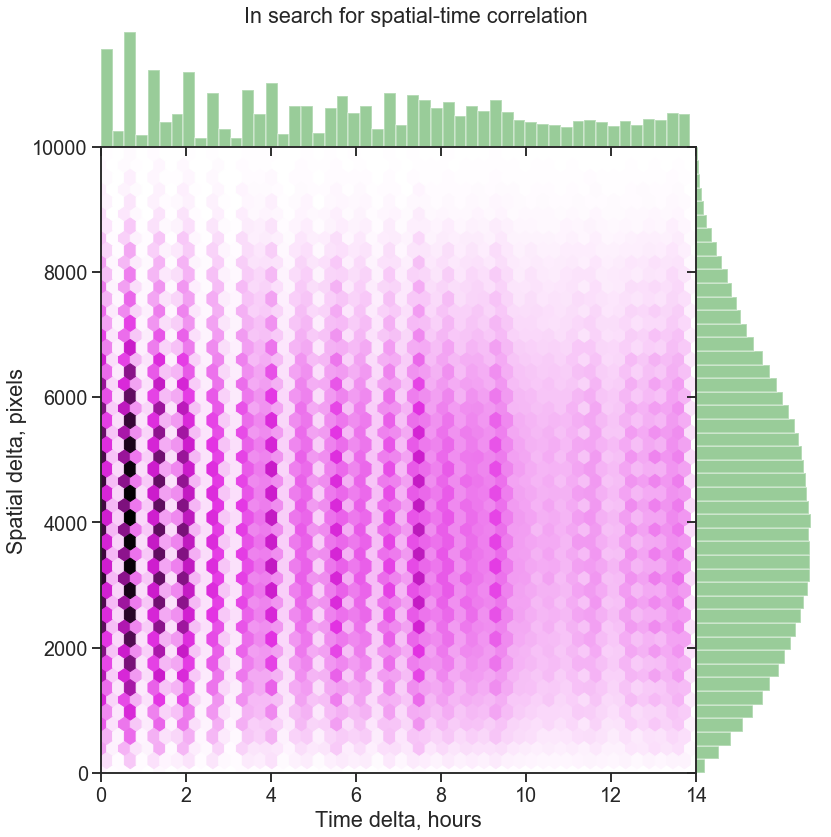

In [6]:
sns.set(style='ticks', color_codes=True)
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3.0})

g = sns.jointplot(x='Time delta, hours', y='Spatial delta, pixels',
                  data=pd.DataFrame(data={'Time delta, hours': tm, 'Spatial delta, pixels': sp}),
                  xlim=(0, 14),
                  ylim=(0, 10000),
                  color="violet",
                  space=0,
                  kind="hex",
                  height=12,
                  ratio=5,
                  joint_kws={"gridsize": 50},
                  marginal_kws={'color': 'green'})
_ = g.fig.suptitle('In search for spatial-time correlation')

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


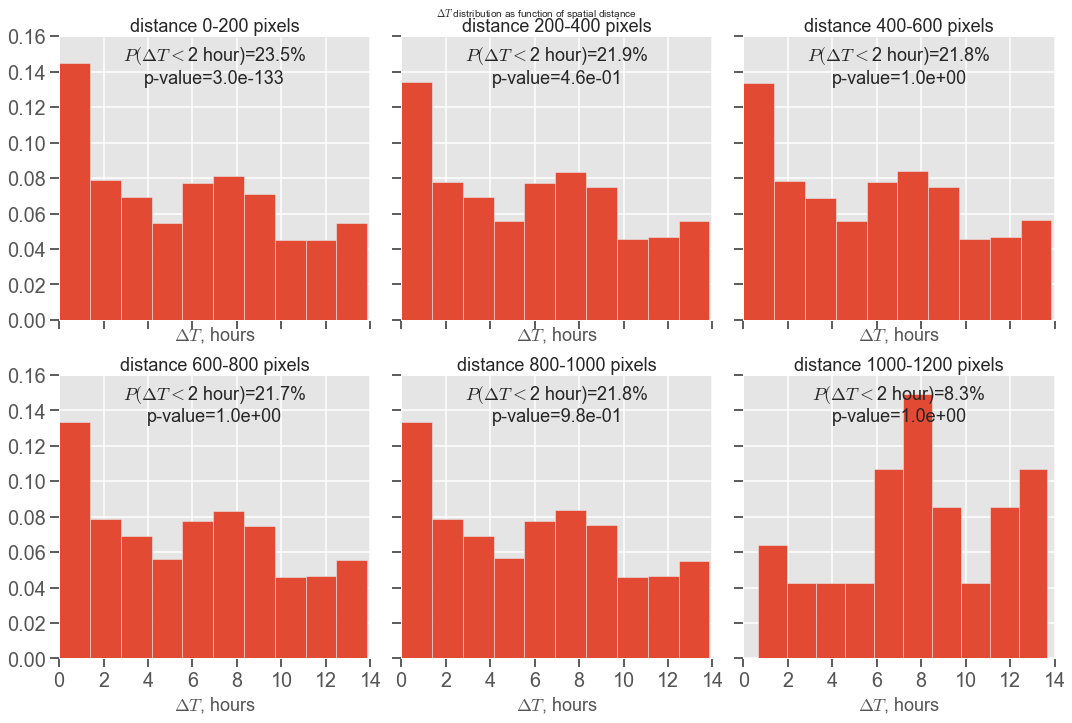

In [26]:
width = 200
steps = np.arange(0, 1200, width)
min_hours = 2
n_cols = 3
n_rows = int(np.ceil(len(steps) / n_cols))
fontsize = 18
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True,
                        tight_layout=True)
for i, step in enumerate(steps):
    ax = axs[i // n_cols, i % n_cols]
    band = (step, step + width)
    idx = np.logical_and(band[0] <= sp, sp < band[1])
    data = tm[idx]
    prob = (data < min_hours).sum() / len(data)
    
    count = [sum(data < min_hours), sum(tm < min_hours)]
    nobs = [len(data), len(tm)]
    stat, pval = proportions_ztest(count, nobs, alternative='larger')
    
    ax.hist(data, density=True)
    ax.set_title(f'distance {band[0]}-{band[1]} pixels', fontsize=fontsize)
    ax.set_xlabel(r'$\Delta T$, hours', fontsize=fontsize)
    ax.text(s=r'$P(\Delta T<$' + f'{min_hours} hour)={prob * 100:0.1f}%\np-value={pval:0.1e}', x=0.5, y=0.9, horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

_ = plt.suptitle(r'$\Delta T$ distribution as function of spatial distance', y=1.0)

In [9]:
sp_max = 1000

time = df['time'].values
xy = df[['POSITION_X', 'POSITION_Y']].values

skip = 20
time = time[::skip]
xy = xy[::skip]

tm = np.abs(time - time[..., np.newaxis])
x2 = np.sum(xy * xy, 1, keepdims=True)
sp = np.sqrt(x2 + x2.T - 2 * np.dot(xy, xy.T))

idx = np.where(~np.eye(tm.shape[0], dtype=bool))
# idx = np.tril_indices(len(tm), k=-1)

sp = sp[idx]
tm = tm[idx]
tm1 = np.repeat(time[..., np.newaxis], time.shape[0], axis=1)[idx]

sp_filter = sp <= sp_max
sp = sp[sp_filter]
tm = tm[sp_filter]
tm1 = tm1[sp_filter]

tm[tm > (tm.max() / 2)] = tm.max() - tm[tm > (tm.max() / 2)]

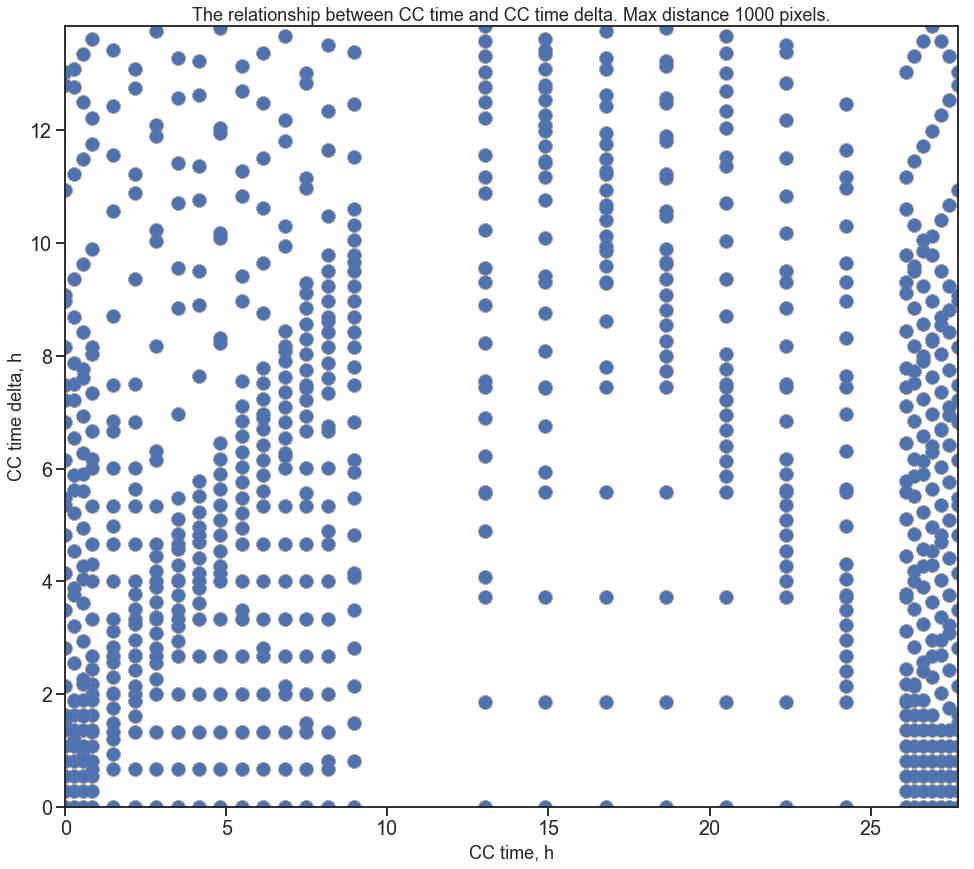

In [22]:
step = 1
fontsize = 18
plt.figure(figsize=(16, 14))
plt.scatter(tm1[::step], tm[::step], alpha=0.01, s=200)
plt.ylim((0, tm.max()))
plt.xlim((tm1[::step].min(), tm1[::step].max()))
plt.xlabel('CC time, h', fontsize=fontsize)
plt.ylabel('CC time delta, h', fontsize=fontsize)
_ = plt.title(f'The relationship between CC time and CC time delta. Max distance {sp_max} pixels.', fontsize=fontsize)

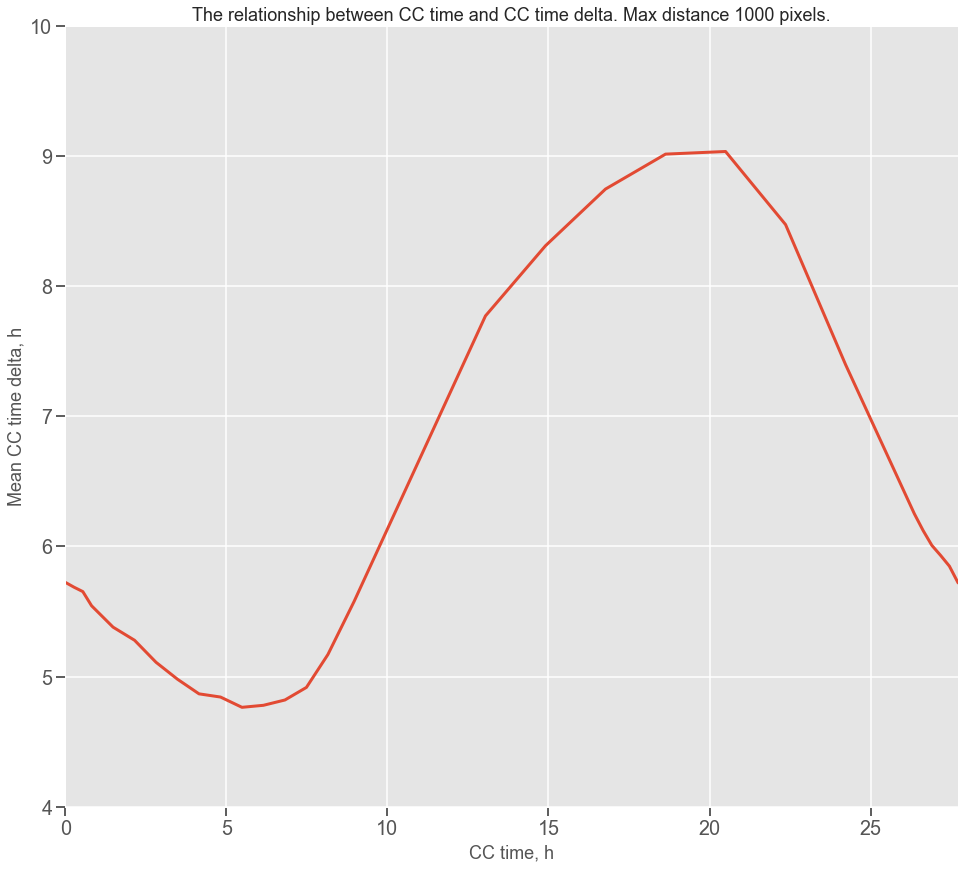

In [25]:
fun = np.mean
tm1_index = np.sort(np.unique(tm1))
tm_average = []
for t in tm1_index:
    tm_average.append(fun(tm[tm1 == t]))
tm_average = np.array(tm_average)

fontsize = 18
plt.figure(figsize=(16, 14))
plt.style.use('ggplot')

plt.plot(tm1_index, tm_average, linewidth=3)
plt.xlim((tm1_index.min(), tm1_index.max()))
plt.xlabel('CC time, h', fontsize=fontsize)
plt.ylabel(f'{fun.__name__.capitalize()} CC time delta, h', fontsize=fontsize)
_ = plt.title(f'The relationship between CC time and CC time delta. Max distance {sp_max} pixels.', fontsize=fontsize)